In [63]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [64]:
# Load dataset
data = pd.read_csv('sentiment140.csv', encoding = "ISO-8859-1")
data.columns = ['target','id','date','flag','user','text']
data.head()

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [65]:
# Choose only relevant columns
data = data[['text', 'target']]
data.head()

,text,target
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [66]:
# Check the classes
data['target'].unique()

array([0, 4], dtype=int64)

In [67]:
# Replace 4 (positive) to 1 
data['target'] = data['target'].replace(4,1)

In [111]:
# Count the number of positive and negative tweets
label_counts = data['target'].value_counts()
num_positive = label_counts[1]
num_negative = label_counts[0]

print(f'Number of positive tweets: {num_positive}')
print(f'Number of negative tweets: {num_negative}')

Number of positive tweets: 800000
Number of negative tweets: 799999


<Axes: xlabel='target', ylabel='count'>

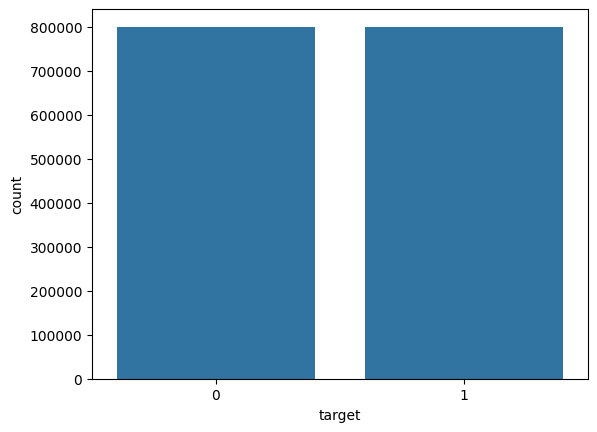

In [68]:

# Display the number of instances for each class in graph
sns.countplot(x='target', data=data)

In [69]:
# Function to clean the data
def clean_text(text):
    text = re.sub(r'((www.[^s]+)|(https?://[^s]+))', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^A-Za-z\s]', '', text) # Remove special characters
    text = re.sub(r'[0-9]+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    return text

# Clean the text column
data['text'] = data['text'].apply(clean_text)


In [70]:
# Display top 5 data
data.head()

,text,target
0,is upset that he cant update his facebook by t...,0
1,i dived many times for the ball managed to sa...,0
2,my whole body feels itchy and like its on fire,0
3,no its not behaving at all im mad why am i he...,0
4,not the whole crew,0


In [71]:
# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kahwei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
# Lemmatization
split = nltk.tokenize.WhitespaceTokenizer()
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    str = ""
    for w in split.tokenize(text):
        str = str + lemmatizer.lemmatize(w) + " "
    return str
data['text'] = data.text.apply(lemmatize_text)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kahwei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,target
0,upset cant update facebook texting might cry r...,0
1,dived many time ball managed save rest go bound,0
2,whole body feel itchy like fire,0
3,behaving im mad cant see,0
4,whole crew,0


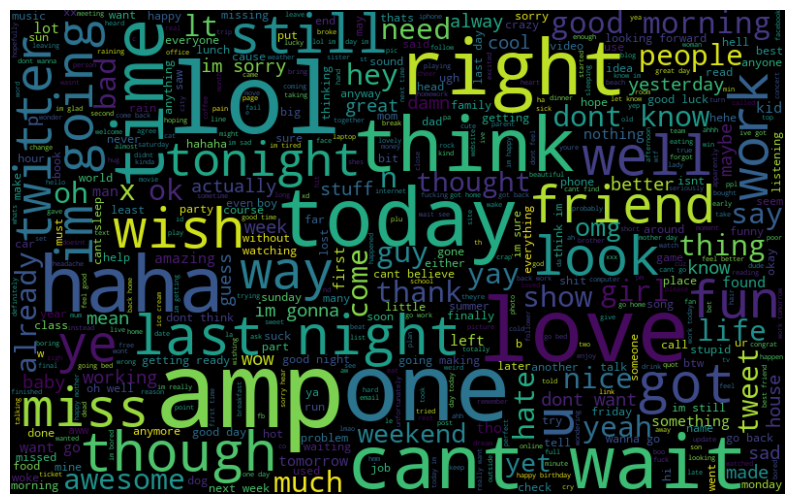

In [125]:
# Wordcloud for all words
all_words = ' '.join([text for text in data['text']])
wordcloud = WordCloud(max_words = 500, width=800, height=500, random_state=1, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

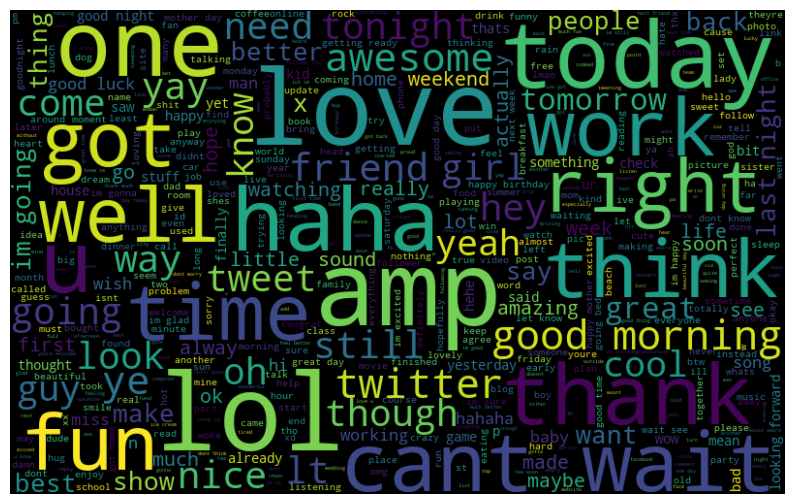

In [126]:
# Wordcloud for positive
positive_words = ' '.join([text for text in data[data['target'] == 1]['text']])
positive_wordcloud = WordCloud(max_words=500, width=800, height=500, random_state=1, max_font_size=110).generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


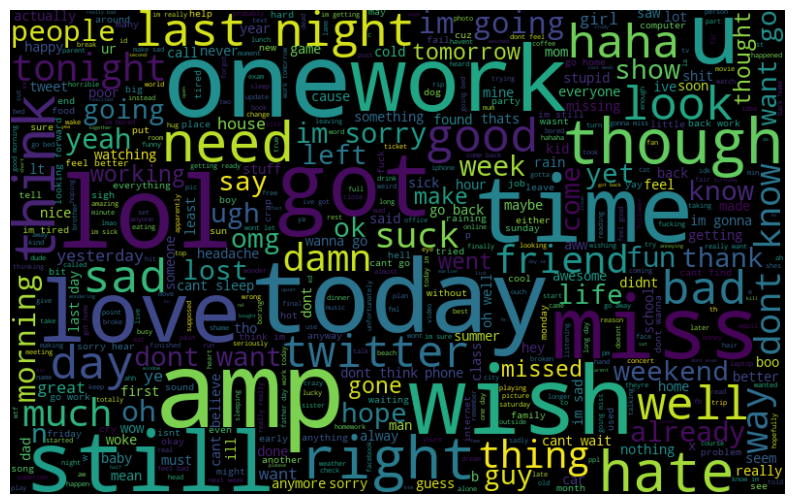

In [127]:
# Wordcloud for negative
negative_words = ' '.join([text for text in data[data['target'] == 0]['text']])
negative_wordcloud = WordCloud(max_words=500, width=800, height=500, random_state=1, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [75]:
# Split text and target
X = data['text']
y = np.array(data['target'])

In [87]:
# Tokenization and padding sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(sequences, maxlen=100)

In [77]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [78]:
# Model parameters
embedding_dim = 100  # Dimensionality of the embedding vector
num_classes = len(data['target'].unique())  # Number of output classes

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm_7 (LSTM)               (None, 128)               117248    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1117377 (4.26 MB)
Trainable params: 1117377 (4.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/5
18000/18000 [==============================] - 2526s 140ms/step - loss: 0.4640 - accuracy: 0.7788 - val_loss: 0.4462 - val_accuracy: 0.7894
Epoch 2/5
18000/18000 [==============================] - 2491s 138ms/step - loss: 0.4357 - accuracy: 0.7956 - val_loss: 0.4389 - val_accuracy: 0.7941
Epoch 3/5
18000/18000 [==============================] - 2704s 150ms/step - loss: 0.4218 - accuracy: 0.8041 - val_loss: 0.4388 - val_accuracy: 0.7947
Epoch 4/5
18000/18000 [==============================] - 2879s 160ms/step - loss: 0.4099 - accuracy: 0.8107 - val_loss: 0.4386 - val_accuracy: 0.7946
Epoch 5/5
18000/18000 [==============================] - 2822s 157ms/step - loss: 0.3999 - accuracy: 0.8164 - val_loss: 0.4437 - val_accuracy: 0.7947


In [80]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

5000/5000 [==============================] - 76s 15ms/step - loss: 0.4414 - accuracy: 0.7953
Test Accuracy: 0.7953


In [131]:
# New tweets to predict
new_tweets = ["I like this.", "I am happy today.", "Awesome trip.", "I hate the world.", "I want to die.", "Everything get messed."]

# Preprocesed new tweets
new_tweets_cleaned = [clean_text(tweet) for tweet in new_tweets]
new_tweets_cleaned = [' '.join([word for word in tweet.split() if word not in stop_words]) for tweet in new_tweets_cleaned]
new_tweets_cleaned = [lemmatize_text(tweet) for tweet in new_tweets_cleaned]
new_sequences = tokenizer.texts_to_sequences(new_tweets_cleaned)
new_X = pad_sequences(new_sequences, maxlen=100)

# Make predictions
predictions = model.predict(new_X)

# Convert predictions to labels
predicted_labels = [1 if p > 0.5 else 0 for p in predictions]

# Output the results with confidence scores
for i in range(len(new_tweets)):
    tweet = new_tweets[i]
    label = predicted_labels[i]
    confidence = predictions[i][0]
    sentiment = 'Positive' if label == 1 else 'Negative'
    print(f'Tweet: \"{tweet}\" - Predicted Sentiment: {sentiment}')

1/1 [==============================] - 0s 38ms/step
Tweet: "I like this." - Predicted Sentiment: Positive
Tweet: "I am happy today." - Predicted Sentiment: Positive
Tweet: "Awesome trip." - Predicted Sentiment: Positive
Tweet: "I hate the world." - Predicted Sentiment: Negative
Tweet: "I want to die." - Predicted Sentiment: Negative
Tweet: "Everything get messed." - Predicted Sentiment: Negative
